In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


In [2]:
x = np.linspace(-2,2, 100)
y = np.linspace(-2,2, 100)
X, Y = np.meshgrid(x, y)

def flu(x, y, c=0.5):
    return np.clip(1 - x**2 - (-y-c*x**2)**2 , 0, None)

Z = flu(X, Y)

LEVELS = [-0.2, 0.1, 0.45, 0.7, 0.9, 1.1]

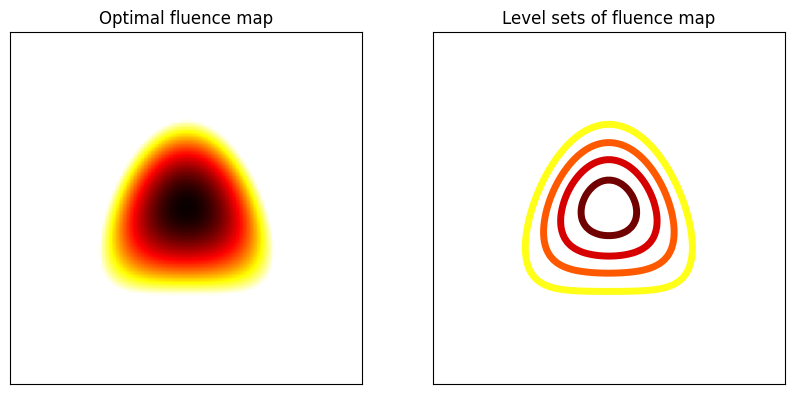

In [3]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(Z[::-1], cmap='hot_r', interpolation='hermite', extent=(-2,2,-2,2))
plt.xticks([])
plt.yticks([])
plt.title('Optimal fluence map')

plt.subplot(1, 2, 2)
plt.contour(X, Y, Z, levels=LEVELS, cmap='hot_r', linewidths=5)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.title('Level sets of fluence map')

# plt.savefig('_fluence_map_discretization.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [4]:
LEAF_WIDTH = 0.25
LEAF_LENGTH = 1

In [5]:
def get_leaf(direction, leaf_number, level, func, reverse=False):
    global LEAF_WIDTH, LEAF_LENGTH
    direction_length = np.sqrt(direction[0]**2 + direction[1]**2)
    direction = (direction[0]/direction_length, direction[1]/direction_length)
    x = direction[1] * LEAF_WIDTH * leaf_number
    x0 = x
    y = -direction[0] * LEAF_WIDTH * leaf_number
    y0 = y
    while x*x + y*y < 10:
        x -= direction[0]*0.01
        y -= direction[1]*0.01
    dx, dy = direction
    dx *= 0.01
    dy *= 0.01
    while func(x,y) < level and x*x + y*y < 100:
        x += dx
        y += dy
    x -= dx
    y -= dy
    if x*x + y*y >= 90:
        x = x0
        y = y0
    rx = x
    ry = y
    y = y - LEAF_WIDTH/2
    if not reverse:
        sx = -LEAF_LENGTH
    else:
        sx = LEAF_LENGTH
    sy = LEAF_WIDTH
    a = np.arctan2(direction[1], direction[0]) * (180/np.pi)
    a %= 180
    return plt.Rectangle((x, y), sx, sy, \
                         edgecolor='black', facecolor='grey', linewidth=2, \
                         rotation_point=(rx,ry), angle=a)


In [6]:
def get_leaf_pair(direction, leaf_number, level, func):
    leaf1 = get_leaf(direction, leaf_number, level, func)
    reverse_direction = (-direction[0], -direction[1])
    leaf2 = get_leaf(reverse_direction, leaf_number, level, func, reverse=True)
    return leaf1, leaf2

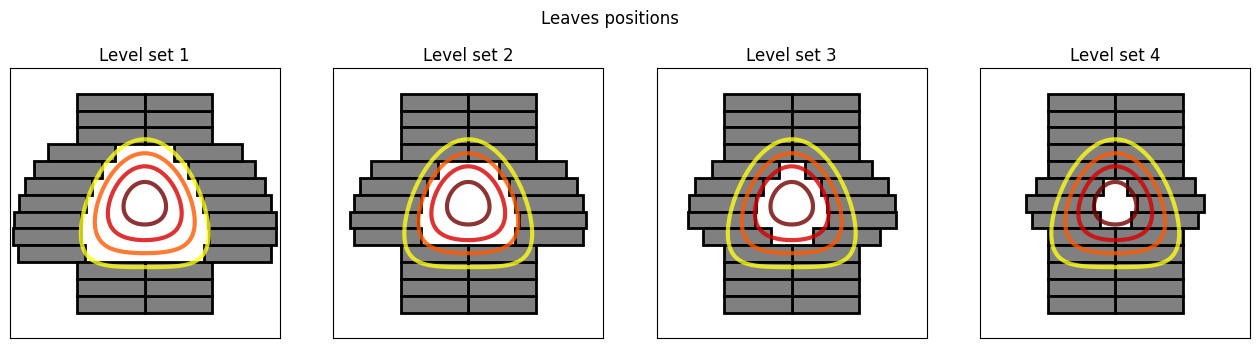

In [7]:
def plot_leaves(flu, direction=(1,0), number_leaves=5, filename=None):
    global LEVELS
    N = len(LEVELS)-2
    plt.figure(figsize=(4*N, 4))
    for i,level in enumerate(LEVELS[1:-1]):
        plt.subplot(1, N, i+1)
        plt.contour(X, Y, Z, levels=LEVELS, cmap='hot_r', linewidths=3, alpha=0.8)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.gca().set_aspect('equal')
        plt.xticks([])
        plt.yticks([])
        for leaf_number in range(-number_leaves, number_leaves+1):
            r1, r2 = get_leaf_pair(direction, leaf_number, level, flu)
            # plot leaves
            plt.gca().add_patch(r1)
            plt.gca().add_patch(r2)
        plt.title(f'Level set {i+1}')
    plt.suptitle('Leaves positions')
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_leaves(flu, (1,0), number_leaves=6)
# plot_leaves(flu, (1,0), number_leaves=6, filename='_fluence_map_leaves.pdf')